## **Validation (1D)**

### **Set Environment**

In [ ]:
from lib.QuantumCalculator import LaplacianEVProcessor1D, InnerProductProcessor
from lib.classical_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# # IonQ Simulator
# import os
# os.environ['IONQ_API_KEY'] = 'your api key'
# my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

# # IBM Hardware
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(instance = 'your crn', token = 'your token', set_as_default=True, overwrite=True)
hardware_backend = QiskitRuntimeService().least_busy()
print(hardware_backend.name)

ibm_yonsei


### **Initialize Sampler**

In [3]:
grid_num = 16
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Design Ansatz**

Number of Parameters: 16


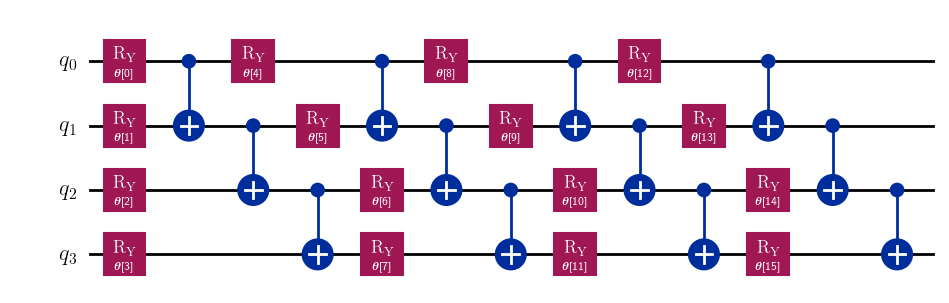

In [4]:
num_qubits = int(np.log2(grid_num))
num_qubits1D = int(num_qubits / 2)
ansatz_depth = 4
param_num = num_qubits * ansatz_depth
parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

def create_parameterized_ansatz(num_qubits, ansatz_depth, parameters):
    qc = QuantumCircuit(num_qubits)
    for depth in range (ansatz_depth):
        for i in range(0,num_qubits):
            qc.ry(parameters[i + depth * (num_qubits)],  i)
        for i in range (0, num_qubits-1):
            qc.cx( i,  (i+1))
    return qc

psi_param_circuit = create_parameterized_ansatz(num_qubits, ansatz_depth, parameters)
print(f"Number of Parameters: {param_num}")
psi_param_circuit.draw('mpl', fold = -1)

### **Periodic Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


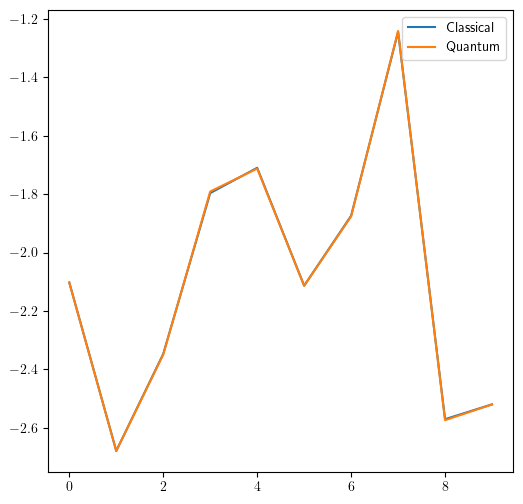

In [5]:
params_list = []
cevs_list = []
A = laplacian_matrix(grid_num, "Periodic")
for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(cpsi @ A @ cpsi)
    
ansatz_list = [psi_param_circuit] * 10
boundary_condition_list = ['P'] * 10

processor = LaplacianEVProcessor1D(
    params_list=params_list,
    ansatz_list=ansatz_list,
    boundary_condition_list=boundary_condition_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()

### **Dirichlet Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


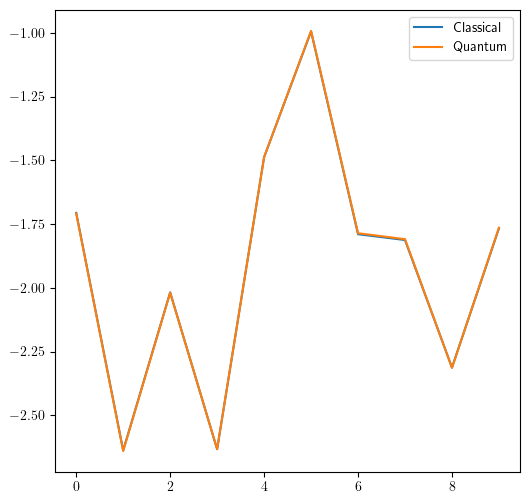

In [ ]:
params_list = []
cevs_list = []
A = laplacian_matrix(grid_num, "Dirichlet")
for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(cpsi @ A @ cpsi)
    
ansatz_list = [psi_param_circuit] * 10
boundary_condition_list = ['D'] * 10

processor = LaplacianEVProcessor1D(
    params_list=params_list,
    ansatz_list=ansatz_list,
    boundary_condition_list=boundary_condition_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()

### **Neumann Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


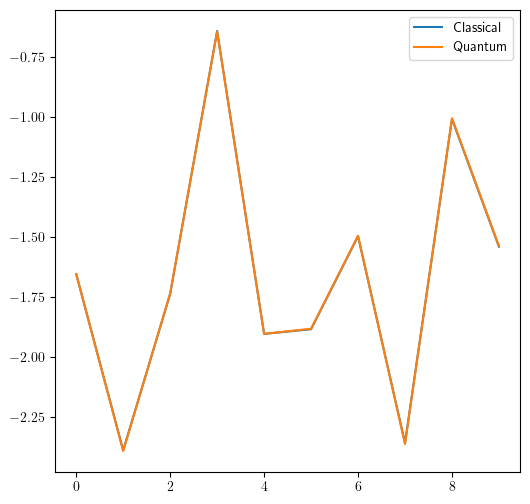

In [ ]:
params_list = []
cevs_list = []
A = laplacian_matrix(grid_num, "Neumann")
for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(cpsi @ A @ cpsi)
    
ansatz_list = [psi_param_circuit] * 10
boundary_condition_list = ['N'] * 10

processor = LaplacianEVProcessor1D(
    params_list=params_list,
    ansatz_list=ansatz_list,
    boundary_condition_list=boundary_condition_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()

### **Numerator Laplacian**

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


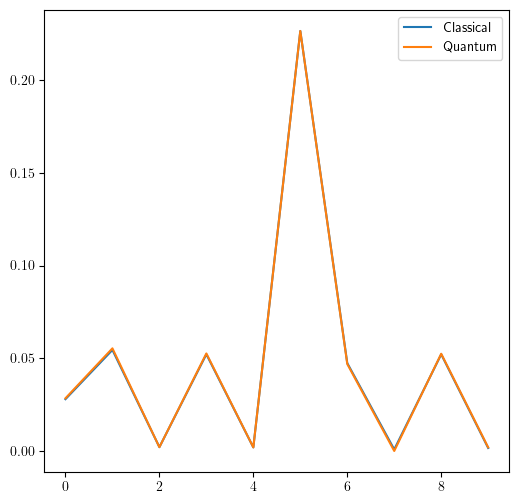

In [6]:
params_list = []
cevs_list = []

f = np.array([np.sin(2 * np.pi * i / grid_num) for i in range (grid_num)])
f_normalized = f / np.linalg.norm(f)
numerator_list = [f_normalized] * 10

for i in range (10):
    params = 4 * np.pi * np.random.rand(param_num)
    params_list.append(params)
    cpsi = make_classical_psi(num_qubits, ansatz_depth, params)
    cevs_list.append(np.inner(cpsi, f_normalized)**2)
    
ansatz_list = [psi_param_circuit] * 10

processor = InnerProductProcessor(
    params_list=params_list,
    ansatz_list=ansatz_list,
    numerator_list = numerator_list,
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

circuits = processor.make_circuits()

transpiled = processor.transpile(circuits, optimization_level = 1)

counts = processor.simulator_execute(transpiled)

qevs_list = processor.make_evs(counts)

plt.figure(figsize = (6,6))
plt.plot(cevs_list, label = "Classical")
plt.plot(qevs_list, label = "Quantum")
plt.legend()
plt.show()